In [ ]:
from __future__ import annotations
import numpy as np
from sempy import ConstantsSI
from typing import Union
from dataclasses import dataclass
ArrayLike = Union[float, np.ndarray]

def lattice_scattering_mobility(
    T: ArrayLike,
    T_ref: float,
    mu_lattice_ref: float,
    alpha_lattice: float = 3.0 / 2.0,
) -> np.ndarray:
  r"""
  Compute the lattice-scattering-limited mobility.

  This model assumes acoustic-phonon scattering, for which the
  mobility follows a power-law temperature dependence:

  .. math::

      \mu_{\mathrm{lat}}(T)
      = \mu_{\mathrm{lat}}(T_{\mathrm{ref}})
        \left( \frac{T}{T_{\mathrm{ref}}} \right)^{-\alpha_{\mathrm{lat}}}


    Parameters
    ----------
    T : float or ndarray
        Temperature(s) in Kelvin.
    T_ref : float
        Reference temperature (K) where mu_lattice_ref is defined.
    mu_lattice_ref : float
        Lattice-limited mobility at T_ref (units: cm^2/(V*s)).
    alpha_lattice : float, optional
        Temperature exponent for acoustic-phonon scattering.
        Typical value is 1.5.

    Returns
    -------
    ndarray
        Lattice-limited mobility mu_lat(T) in cm^2/(V*s).
  """
  T = np.asarray(T, dtype=float)
  return mu_lattice_ref * (T / T_ref) ** (-alpha_lattice)


def impurity_scattering_mobility(
    T: ArrayLike,
    N_I: ArrayLike,
    T_ref: float,
    N_I_ref: float,
    mu_impurity_ref: float,
    alpha_impurity: float = 3.0 / 2.0,
) -> np.ndarray:
    r"""
    Ionized-impurity-limited mobility:

        μ_imp(T, N_I)
          = μ_imp(T_ref, N_I_ref)
            * (T / T_ref)^(+α_imp)
            * (N_I_ref / N_I)

    α_imp ≈ 3/2 for screened Coulomb scattering.
    """
    T  = np.asarray(T, dtype=float)
    N_I = np.asarray(N_I, dtype=float)
    return (
        mu_impurity_ref
        * (T / T_ref) ** (alpha_impurity)
        * (N_I_ref / N_I)
    )


@dataclass
class SemiconductorMaterial:
  """
  Semiconductor material with absolute effective mass.

  m_eff_n : float
      Electron effective mass in kg (NOT normalized by me0).
  m_eff_p : float
      Hole effective mass in kg (NOT normalized by me0).
  """
  m_eff_n: float
  m_eff_p: float

@dataclass
class CarrierMobilityModel:
  r"""
  Mobility model for a single carrier type (electron or hole).

  Parameters
  ----------
  m_eff : float
      Effective mass m* in kg for this carrier (electron or hole).
  mu_lattice_ref : float
      Lattice-limited mobility μ_lat(T_lat_ref) in cm^2/(V·s).
  mu_impurity_ref : float
      Impurity-limited mobility μ_imp(T_imp_ref, N_I_ref)
      in cm^2/(V·s).
  N_I_ref : float
      Reference impurity concentration (cm^-3) for μ_imp_ref.
  T_lat_ref : float
      Reference temperature (K) for lattice scattering.
  T_imp_ref : float
      Reference temperature (K) for impurity scattering.
  alpha_lat : float
      Exponent \alpha_lat in μ_lat ∝ T^(-\alpha_lat).
  alpha_imp : float
      Exponent \alpha_imp in μ_imp ∝ T^(+\alpha_imp).
  """

  m_eff: float
  mu_lattice_ref: float
  mu_impurity_ref: float
  N_I_ref: float
  T_lat_ref: float = 300.0
  T_imp_ref: float = 300.0
  alpha_lat: float = 3.0 / 2.0
  alpha_imp: float = 3.0 / 2.0

  # --- 1.1 Thermal velocity --------------------------------------------

  def thermal_velocity(self, T: ArrayLike) -> np.ndarray:
    r"""
    Thermal (rms) velocity from equipartition:

        (1/2) m* v_th^2 = (3/2) k_B T.
    """
    T = np.asarray(T, dtype=float)
    return np.sqrt(3.0 * ConstantsSI.k_B * T / self.m_eff)

    # --- 1.2 τ ↔ μ conversions -------------------------------------------

  def tau_from_mu(self, mu_cm2_Vs: ArrayLike) -> np.ndarray:
    r"""
    Mean free time τ_c from mobility μ:

        μ = q τ_c / m*

    μ is in cm^2/(V·s); internally convert to m^2/(V·s).
    """
    mu_m2 = np.asarray(mu_cm2_Vs, dtype=float) * 1e-4  # cm^2 → m^2
    return mu_m2 * self.m_eff / ConstantsSI.q

  def mu_from_tau(self, tau_c: ArrayLike) -> np.ndarray:
    r"""
    Mobility μ from mean free time τ_c:

        μ = q τ_c / m*

    Returned μ in cm^2/(V·s).
    """
    tau_c = np.asarray(tau_c, dtype=float)
    mu_m2 = ConstantsSI.q * tau_c / self.m_eff
    return mu_m2 * 1e4  # m^2 → cm^2

  # --- 1.3 Scattering-limited mobilities -------------------------------
  def mu_lattice(self, T: ArrayLike) -> np.ndarray:
    r"""
      Lattice-scattering-limited mobility:

          μ_lat(T) = μ_lat_ref * (T / T_lat_ref)^(-\alpha_lat).
    """
    return lattice_scattering_mobility(
      T=T,
      T_ref=self.T_lat_ref,
      mu_lattice_ref=self.mu_lattice_ref,
      alpha_lattice=self.alpha_lat,
    )

  def mu_impurity(self, T: ArrayLike, N_I: ArrayLike) -> np.ndarray:
    r"""
    Impurity-scattering-limited mobility:

    μ_imp(T, N_I)
      = μ_imp_ref
        * (T / T_imp_ref)^(+α_imp)
        * (N_I_ref / N_I).
    """
    return impurity_scattering_mobility(
      T=T,
      N_I=N_I,
      T_ref=self.T_imp_ref,
      N_I_ref=self.N_I_ref,
      mu_impurity_ref=self.mu_impurity_ref,
      alpha_impurity=self.alpha_imp,
    )

    # --- 1.4 Total mobility (Matthiessen) --------------------------------

  def mu_total(
      self, 
      T: ArrayLike, 
      N_I: ArrayLike
  ) -> np.ndarray:
    r"""
    Total mobility using Matthiessen’s rule:

        1 / μ_tot = 1 / μ_lat + 1 / μ_imp.
    """
    mu_lat = self.mu_lattice(T)
    mu_imp = self.mu_impurity(T, N_I)

    inv_mu = 1.0 / mu_lat + 1.0 / mu_imp
    return 1.0 / inv_mu

    # --- 1.5 Drift velocity ----------------------------------------------
  def drift_velocity(
      self,
      T: ArrayLike,
      N_I: ArrayLike,
      E: ArrayLike,
  ) -> np.ndarray:
      r"""
      Drift velocity:

          v_d(T, N_I, E) = μ_tot(T, N_I) * E.

      μ is in cm^2/(V·s), E in V/m, so:

          v_d [m/s].
      """
      mu_cm2 = self.mu_total(T, N_I)
      mu_m2 = mu_cm2 * 1e-4  # cm^2 → m^2
      E = np.asarray(E, dtype=float)
      return mu_m2 * E


# -------------------------------------------------------------------------
# 2. Semiconductor-level wrapper (both n and p)
# -------------------------------------------------------------------------


@dataclass
class SemiconductorMobility:
    """
    Convenience wrapper holding both electron and hole mobility models.

    Parameters
    ----------
    electron : CarrierMobilityModel
        Mobility model for electrons (n-type carriers).
    hole : CarrierMobilityModel
        Mobility model for holes (p-type carriers).
    """

    electron: CarrierMobilityModel
    hole: CarrierMobilityModel

    # --- 2.1 Electron mobility / drift -----------------------------------

    def mu_n(self, T: ArrayLike, N_I: ArrayLike) -> np.ndarray:
        """Total electron mobility μ_n(T, N_I)."""
        return self.electron.mu_total(T, N_I)

    def mu_n_lattice(self, T: ArrayLike) -> np.ndarray:
        """Lattice-limited μ_n(T)."""
        return self.electron.mu_lattice(T)

    def mu_n_impurity(self, T: ArrayLike, N_I: ArrayLike) -> np.ndarray:
        """Impurity-limited μ_n(T, N_I)."""
        return self.electron.mu_impurity(T, N_I)

    def drift_velocity_n(
        self,
        T: ArrayLike,
        N_I: ArrayLike,
        E: ArrayLike,
    ) -> np.ndarray:
        """Electron drift velocity v_dn(T, N_I, E)."""
        return self.electron.drift_velocity(T, N_I, E)

    # --- 2.2 Hole mobility / drift ---------------------------------------

    def mu_p(self, T: ArrayLike, N_I: ArrayLike) -> np.ndarray:
        """Total hole mobility μ_p(T, N_I)."""
        return self.hole.mu_total(T, N_I)

    def mu_p_lattice(self, T: ArrayLike) -> np.ndarray:
        """Lattice-limited μ_p(T)."""
        return self.hole.mu_lattice(T)

    def mu_p_impurity(self, T: ArrayLike, N_I: ArrayLike) -> np.ndarray:
        """Impurity-limited μ_p(T, N_I)."""
        return self.hole.mu_impurity(T, N_I)

    def drift_velocity_p(
        self,
        T: ArrayLike,
        N_I: ArrayLike,
        E: ArrayLike,
    ) -> np.ndarray:
        """Hole drift velocity v_dp(T, N_I, E)."""
        return self.hole.drift_velocity(T, N_I, E)

from sempy import ConstantsSI

si_material = SemiconductorMaterial(
   m_eff_n = 0.26 * ConstantsSI.me0,
   m_eff_p =  0.39 * ConstantsSI.me0
)


# Electron mobility calibration
n_model = CarrierMobilityModel(
    m_eff=si_material.m_eff_n,
    mu_lattice_ref=1500.0,   # cm^2/(V·s) at T_lat_ref (phonon-limited)
    mu_impurity_ref=1500.0,   # cm^2/(V·s) at T_imp_ref, N_I_ref
    N_I_ref=1e16,        # cm^-3
    T_lat_ref=300.0,
    T_imp_ref=300.0,
    alpha_lat=1.5,
    alpha_imp=1.5,
)

# Hole mobility calibration
p_model = CarrierMobilityModel(
    m_eff=si_material.m_eff_p,
    mu_lattice_ref=450.0,    # cm^2/(V·s) at T_lat_ref
    mu_impurity_ref=450.0,    # cm^2/(V·s) at T_imp_ref, N_I_ref
    N_I_ref=1e16,        # cm^-3
    T_lat_ref=300.0,
    T_imp_ref=300.0,
    alpha_lat=1.5,
    alpha_imp=1.5,
)

si_mob = SemiconductorMobility(electron=n_model, hole=p_model)

T = np.linspace(150, 600, 200)
N_I = 1e16  # cm^-3

mu_n = si_mob.mu_n(T, N_I)
mu_p = si_mob.mu_p(T, N_I)

v_dn = si_mob.drift_velocity_n(T=300.0, N_I=N_I, E=1e3)  # [m/s]
v_dp = si_mob.drift_velocity_p(T=300.0, N_I=N_I, E=1e3)  # [m/s]


In [4]:

# -------------------------------------------------------------------
# 2. Example usage: equilibrium p-n junction
# -------------------------------------------------------------------

silicon = SemiconductorMaterial(
    T     = 300,
    Eg    = 1.12,
    eps_r = 11.7,
    ni    = 1e10 * 1e6,   # 1e10 cm^-3 -> 1e16 m^-3
    mu_n  = 1350e-4,
    mu_p  =  480e-4
)

doping_profile = DopingProfile(
    NA = 1e17 * 1e6,      # 1e17 cm^-3 -> 1e23 m^-3
    ND = 1e16 * 1e6       # 1e16 cm^-3 -> 1e22 m^-3
)

pn = PNJunction(material=silicon, doping=doping_profile)

silicon.summary()
doping_profile.summary()

V_bi = pn.builtin_potential()
W, Wp, Wn = pn.depletion_widths(V_app=0.0)
print(f"\nV_bi = {V_bi:.3f} V")
print(f"W   = {W*1e6:.2f} µm  (Wp = {Wp*1e6:.2f} µm, Wn = {Wn*1e6:.2f} µm)")

# Grid, Poisson, bands, carriers
x = pn.make_grid(V_app=0.0, left_factor=1.5, right_factor=1.5, N=600)
phi, E = pn.solve_poisson(x, V_app=0.0)
EC, EV, EF = pn.band_edges(x, phi)
n_x, p_x = pn.carrier_profiles(EC, EV, EF)
J = pn.currents(x, E, n_x, p_x)

# Quick band diagram plot (for notebook)
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x*1e6, EC, 'k', lw=2, label=r"$E_C$")
ax.plot(x*1e6, EV, 'k', lw=6, alpha=0.3, label=r"$E_V$")
ax.plot(x*1e6, EF, 'b--', lw=1.5, label=r"$E_F$")
ax.set_xlabel("x (µm)")
ax.set_ylabel("Energy (arb. eV)")
ax.set_title("Equilibrium p-n junction band diagram (numerical)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


TypeError: SemiconductorMaterial.__init__() got an unexpected keyword argument 'T'

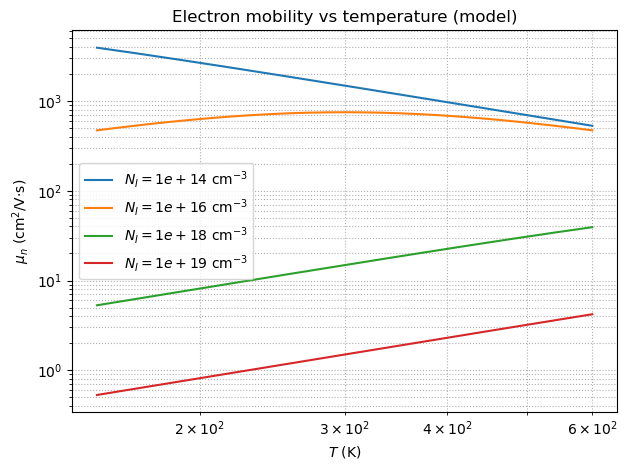

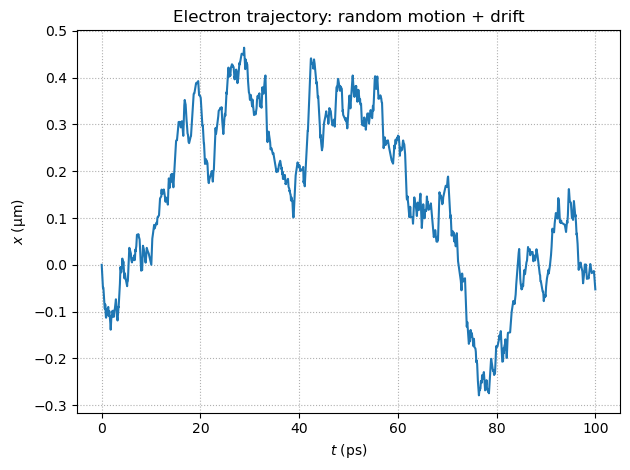

In [ ]:
"""
mobility.py

Pedagogical implementation of carrier mobility for an n-type semiconductor.

- Thermal velocity v_th(T)
- Lattice-limited mobility μ_lat(T)
- Impurity-limited mobility μ_imp(T, N_I)
- Total mobility μ(T, N_I) via Matthiessen's rule
- Drift velocity v_d = μE
- Simple Monte Carlo trajectory to illustrate drift + random motion

Units:
- T in K
- N_I in cm^-3 (converted internally to m^-3)
- μ in cm^2/(V·s)
- E in V/m
- length in m, time in s, velocity in m/s (for trajectories)
"""

from __future__ import annotations
import numpy as np

from sempy import ConstantsSI
from dataclasses import dataclass


@dataclass
class SemiconductorMaterial:
    m_eff: float # effective mass
    

def get_lattice_scattering_mobility(T: np.ndarray, Tref: float, mu_lattice: float):
    return 

# -------------------------------------------------------------------------
# 1. Core model
# -------------------------------------------------------------------------


class ElectronMobilityModel:
    """
    Electron mobility model for an n-type semiconductor.

    Parameters
    ----------
    m_eff_rel : float
        Effective mass in units of the free-electron mass m0.
        Example: Si conduction band ~ 0.26 m0 (density-of-states mass).
    mu_lat_300 : float
        Lattice-limited mobility μ_lat at T0 = 300 K, in cm^2/(V·s).
    mu_imp_300 : float
        Impurity-limited mobility μ_imp at T0 = 300 K and reference
        impurity concentration N_I_ref, in cm^2/(V·s).
    N_I_ref : float
        Reference impurity concentration (cm^-3) associated with mu_imp_300.
    alpha_lat : float
        Exponent for lattice scattering: μ_lat ∝ T^(-alpha_lat).
        Theoretically ~ 3/2.
    beta_imp : float
        Exponent for impurity scattering: μ_imp ∝ T^(beta_imp).
        Theoretically ~ 3/2.
    """

    def __init__(
        self,
        m_eff: float,       # Si example
        mu_lat_300: float = 1500.0,    # cm^2/(V·s), order of magnitude
        mu_imp_300: float = 1500.0,    # cm^2/(V·s), same order at low doping
        N_I_ref: float   = 1e16,       # cm^-3
        alpha_lat: float = 1.5,
        beta_imp: float  = 1.5,
    ):
        self.m_eff = m_eff
        self.mu_lat_300 = mu_lat_300
        self.mu_imp_300 = mu_imp_300
        self.N_I_ref    = N_I_ref
        self.alpha_lat  = alpha_lat
        self.beta_imp   = beta_imp
        self.T0         = 300.0

    # --- 1.1 Thermal velocity --------------------------------------------
    def get_thermal_velocity(self, T: float | np.ndarray) -> np.ndarray:
        r"""
        Average thermal velocity (rms) from equipartition:
            (1/2) m* v_th^2 = (3/2) k_B T
        """
        T = np.asarray(T, dtype=float)
        return np.sqrt(3.0 * ConstantsSI.k_B * T / self.m_eff)

    # --- 1.2 Mean free time from mobility (inverse mapping) ---------------

    @staticmethod
    def tau_from_mu(mu_cm2_Vs: float | np.ndarray,
                    m_eff: float) -> np.ndarray:
        """
        Compute mean free time τ_c from mobility μ:

            μ = q τ_c / m*

        μ is given in cm^2/(V·s); internally convert to m^2/(V·s).
        """
        mu = np.asarray(mu_cm2_Vs, dtype=float) * 1e-4  # cm^2 -> m^2
        return mu * m_eff / q

    @staticmethod
    def mu_from_tau(tau_c: float | np.ndarray,
                    m_eff: float) -> np.ndarray:
        """
        Compute mobility μ from mean free time τ_c:

            μ = q τ_c / m*

        Returned μ in cm^2/(V·s).
        """
        tau_c = np.asarray(tau_c, dtype=float)
        mu_m2 = q * tau_c / m_eff
        return mu_m2 * 1e4  # m^2 -> cm^2

    # --- 1.3 Scattering-limited mobilities -------------------------------

    def mu_lattice(self, T: float | np.ndarray) -> np.ndarray:
        r"""
        Lattice-scattering-limited mobility:

            μ_lat(T) = μ_lat(300 K) (T / 300 K)^(-alpha_lat)

        Typically alpha_lat ≈ 3/2.
        """
        T = np.asarray(T, dtype=float)
        return self.mu_lat_300 * (T / self.T0) ** (-self.alpha_lat)

    def mu_impurity(self,
                    T: float | np.ndarray,
                    N_I: float | np.ndarray) -> np.ndarray:
        r"""
        Impurity-scattering-limited mobility:

            μ_imp(T, N_I) ∝ T^(beta_imp) / N_I

        normalized so that

            μ_imp(300 K, N_I_ref) = mu_imp_300.
        """
        T  = np.asarray(T, dtype=float)
        NI = np.asarray(N_I, dtype=float)
        factor_T  = (T / self.T0) ** self.beta_imp
        factor_NI = self.N_I_ref / NI
        return self.mu_imp_300 * factor_T * factor_NI

    # --- 1.4 Total mobility via Matthiessen's rule -----------------------

    def mu_total(self,
                 T: float | np.ndarray,
                 N_I: float | np.ndarray) -> np.ndarray:
        r"""
        Total mobility using Matthiessen's rule:

            1 / μ = 1 / μ_lat + 1 / μ_imp
        """
        mu_lat = self.mu_lattice(T)
        mu_imp = self.mu_impurity(T, N_I)

        inv_mu = 1.0 / mu_lat + 1.0 / mu_imp
        return 1.0 / inv_mu

    # --- 1.5 Drift velocity ----------------------------------------------

    def drift_velocity(self,
                       T: float | np.ndarray,
                       N_I: float | np.ndarray,
                       E: float | np.ndarray) -> np.ndarray:
        """
        Drift velocity v_d(T, N_I, E):

            v_d = μ(T, N_I) * E

        μ is in cm^2/(V·s), E in V/m, so we convert μ to m^2/(V·s):

            v_d [m/s].
        """
        mu_cm2 = self.mu_total(T, N_I)
        mu_m2  = mu_cm2 * 1e-4
        E      = np.asarray(E, dtype=float)
        return mu_m2 * E


# -------------------------------------------------------------------------
# 2. Simple Monte Carlo trajectory (biased random walk)
# -------------------------------------------------------------------------

def simulate_trajectory(
    model: ElectronMobilityModel,
    T: float = 300.0,
    N_I: float = 1e16,
    E: float = 1e3,
    dt: float = 1e-14,
    n_steps: int = 5000,
    seed: int | None = 1234,
):
    """
    Simulate the 1D trajectory of a single electron undergoing
    random thermal motion + drift in an electric field.

    Model:
    - Between collisions, electron experiences acceleration:
          a = -qE / m*
    - Collisions occur with Poisson statistics with mean time τ_c.
    - After a collision, velocity is redrawn from a thermal (Gaussian) distribution.

    Parameters
    ----------
    model : ElectronMobilityModel
        Mobility model defining m_eff and μ(T, N_I).
    T : float
        Lattice temperature in K.
    N_I : float
        Impurity concentration in cm^-3.
    E : float
        Electric field (V/m). Positive E accelerates electrons
        in negative x; here we track their velocity component.
    dt : float
        Time step (s). Choose dt << τ_c.
    n_steps : int
        Number of time steps.
    seed : int or None
        Random seed.

    Returns
    -------
    t : ndarray, shape (n_steps+1,)
        Time axis (s).
    x : ndarray, shape (n_steps+1,)
        Electron position (m).
    v : ndarray, shape (n_steps+1,)
        Electron velocity (m/s).
    """

    rng = np.random.default_rng(seed)

    # Thermal velocity (rms) and 1D component std dev
    v_th = model.thermal_velocity(T)     # 3D rms
    sigma_v = v_th / np.sqrt(3.0)        # 1D component

    # Mean free time from mobility at this T, N_I
    mu_total = model.mu_total(T, N_I)    # cm^2/(V·s)
    tau_c = model.tau_from_mu(mu_total, model.m_eff)

    # Acceleration between collisions
    a = -q * E / model.m_eff

    # Initialise arrays
    t = np.linspace(0.0, n_steps * dt, n_steps + 1)
    x = np.zeros_like(t)
    v = np.zeros_like(t)

    # Initial thermal velocity (1D)
    v[0] = rng.normal(loc=0.0, scale=sigma_v)

    # Precompute scatter probability per step
    p_scatter = dt / tau_c
    if p_scatter > 0.1:
        print(
            "[Warning] dt is not much smaller than τ_c; "
            "reduce dt for a more accurate simulation."
        )

    # Time stepping
    for n in range(n_steps):
        # Decide if a collision happens in this step
        if rng.random() < p_scatter:
            # Reset velocity to new thermal draw
            v[n] = rng.normal(loc=0.0, scale=sigma_v)

        # Update velocity due to field
        v[n + 1] = v[n] + a * dt
        # Update position
        x[n + 1] = x[n] + v[n + 1] * dt

    return t, x, v


# -------------------------------------------------------------------------
# 3. Example usage
# -------------------------------------------------------------------------

  import matplotlib.pyplot as plt

  # Example: Silicon-like parameters
  model = ElectronMobilityModel(
      m_eff_rel=0.26,
      mu_lat_300=1500.0,
      mu_imp_300=1500.0,
      N_I_ref=1e16,
      alpha_lat=1.5,
      beta_imp=1.5,
  )

  # --- 3.1 Mobility vs temperature for different dopings --------------

  T = np.linspace(150, 600, 200)  # K
  dopings = [1e14, 1e16, 1e18, 1e19]  # cm^-3

  plt.figure()
  for N_I in dopings:
      mu = model.mu_total(T, N_I)
      plt.loglog(T, mu, label=fr"$N_I = {N_I:.0e}\ \mathrm{{cm^{{-3}}}}$")
  plt.xlabel(r"$T$ (K)")
  plt.ylabel(r"$\mu_n$ (cm$^2$/V·s)")
  plt.title("Electron mobility vs temperature (model)")
  plt.grid(True, which="both", ls=":")
  plt.legend()
  plt.tight_layout()

  # --- 3.2 Single trajectory -----------------------------------------

  t, x, v = simulate_trajectory(
      model,
      T=300.0,
      N_I=1e16,
      E=1e3,         # V/m
      dt=1e-14,
      n_steps=10000,
  )

  plt.figure()
  plt.plot(t * 1e12, x * 1e6)
  plt.xlabel(r"$t$ (ps)")
  plt.ylabel(r"$x$ (µm)")
  plt.title("Electron trajectory: random motion + drift")
  plt.grid(True, ls=":")
  plt.tight_layout()

  plt.show()
